# Neural Network Training (Run on a GPU)

References: 

https://github.com/shubham3121/music-generation-using-rnn 

https://www.hackerearth.com/blog/developers/jazz-music-using-deep-learning/

## Imports

In [ ]:
!pip install mgzip
!pip install keras-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from matplotlib import pyplot as plt
import mgzip
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import *
from keras.initializers import Constant
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import *

from keras_nlp.layers import PositionEmbedding

## Hyperparameters

In [ ]:
# Best hyperparameters so far:
# 72% training accuracy and 63% validation accuracy:
#   lr = 0.003 with num_heads = 10 with beta1 = 0.96 with feed_forward_dim = 512
#   with embed_dim = 'auto' (72) with 3 transformer blocks with with dropout = 0.3
#   Ended up stopping at epoch 118.

dropout_rate = 0.1 * 3
embed_dim = 'auto' #256 # Embedding size for each token
feed_forward_dim = 256 * 2

num_heads = 10 #10 #8  # Number of attention heads

lr = 0.003 #0.002
beta1 = 0.96 #0.95
#optimizer = Adam(schedules.ExponentialDecay(lr, decay_steps=20, decay_rate=0.9))
optimizer = Adam(lr, beta1)
batch = 128 * 4 #16

validation_set = True
if validation_set:
  max_epochs = 200
  early_stopping = True
else:
  max_epochs = 300
  early_stopping = False

data_augmentation = True

## Load Data

In [ ]:
with mgzip.open('notes_data.pickle.gz', 'rb') as filepath:   
    notes = pickle.load(filepath)
    note_to_int = pickle.load(filepath)
    int_to_note = pickle.load(filepath)
    n_vocab = pickle.load(filepath)

#with mgzip.open('track_data.pickle.gz', 'rb') as filepath:
#    track_data = pickle.load(filepath)
    

ints = np.array([note_to_int[note] for note in notes])
idx = 100 * ((len(ints) - 1) // 100)

X = ints[:idx].reshape((-1, 100))
Y = ints[1:idx+1].reshape((-1, 100))

if validation_set:
  x_train, x_val, y_train, y_val = train_test_split(X, Y, random_state=0, test_size=0.1)
else:
  if data_augmentation:
    # See: https://lilianweng.github.io/posts/2022-04-15-data-gen/ 
    x_train = np.vstack((X, X + np.random.normal(scale=2, size=X.shape).round()))
    y_train = np.vstack((Y, Y))
  else:
    x_train = X
    y_train = Y

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch)

# Transformer code

In [ ]:
n_semitones = int(int_to_note[n_vocab-1][0]) + 1 # Include 0
n_categories = n_semitones + 3 # add 3 for dead, tied, and rest notes.

n_durations = int(np.log2(max([v[1] for v in int_to_note.values()]))) + 1

token_embeddings = np.zeros((n_vocab, n_categories))

for k, v in int_to_note.items():
  if v[0] == 'tied':
    idx = -3
  elif v[0] == 'rest':
    idx = -2
  elif v[0] == 'dead':
    idx = -1
  else:
    idx = int(v[0].split('_')[0])
  
  token_embeddings[k][idx] = 1


other_embeddings = np.zeros((n_vocab, n_durations + 2)) # Add 2 for isDotted and palmMute

for k, v in int_to_note.items():
  duration = int(v[1])
  idx = int(np.log2(duration))
  other_embeddings[k][idx] = 1

  other_embeddings[k][-2] = v[2]
  other_embeddings[k][-1] = v[3]


token_embeddings = np.hstack((token_embeddings, other_embeddings))
token_embeddings -= token_embeddings.mean()

if embed_dim == 'auto':
  embed_dim = token_embeddings.shape[1]

In [ ]:
# Code taken from https://keras.io/examples/generative/text_generation_with_miniature_gpt/

def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [Dense(ff_dim, activation="relu"),
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        #self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim,
                                    embeddings_initializer=Constant(token_embeddings))
        #self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.pos_emb = PositionEmbedding(sequence_length=maxlen)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        #positions = tf.range(start=0, limit=maxlen, delta=1)
        #positions = self.pos_emb(positions)
        x = self.token_emb(x)
        positions = self.pos_emb(x)
        return x + positions


In [ ]:
vocab_size = n_vocab
maxlen = 100


def create_model():
    inputs = Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    
    #transformer_blocks = keras.Sequential([TransformerBlock(embed_dim, num_heads, feed_forward_dim) for _ in range(num_transformer_blocks)])
    #x = transformer_blocks(x)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim, rate=dropout_rate)
    x = transformer_block(x)
    transformer_block2 = TransformerBlock(embed_dim, num_heads, feed_forward_dim, rate=dropout_rate)
    x = transformer_block2(x)
    transformer_block3 = TransformerBlock(embed_dim, num_heads, feed_forward_dim, rate=dropout_rate)
    x = transformer_block3(x)

    #outputs = Dense(vocab_size, name='dense')(x)
    x = Dense(vocab_size, activation='sigmoid')(x)
    outputs = Dense(vocab_size, name='dense')(x)

    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer, loss=[loss_fn, None], metrics=['accuracy']
    )  # No loss and optimization based on word embeddings from transformer block
    return model

# Training

In [ ]:
model = create_model()

if validation_set:
  validation_data = (x_val, y_val)
  if early_stopping:
    callbacks = [EarlyStopping(monitor='val_dense_loss', mode='min', patience=8,
                              verbose=1, restore_best_weights=True)]
else:
  validation_data = None
  callbacks = None

# Should get at least ~34% training and 34% validation accuracy by epoch 10
# Should get at least ~59% training and 54% validation accuracy be epoch 50
history = model.fit(train_dataset, epochs=max_epochs, batch_size=batch, validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/200
10/10 [==============================] - 15s 815ms/step - loss: 6.0362 - dense_loss: 6.0362 - dense_accuracy: 0.0743 - dense_6_accuracy: 4.3044e-04 - val_loss: 5.4219 - val_dense_loss: 5.4219 - val_dense_accuracy: 0.1321 - val_dense_6_accuracy: 3.6697e-05
Epoch 2/200
10/10 [==============================] - 6s 630ms/step - loss: 5.0885 - dense_loss: 5.0885 - dense_accuracy: 0.1322 - dense_6_accuracy: 1.8360e-04 - val_loss: 4.7409 - val_dense_loss: 4.7409 - val_dense_accuracy: 0.1520 - val_dense_6_accuracy: 4.4037e-04
Epoch 3/200
10/10 [==============================] - 6s 635ms/step - loss: 4.5607 - dense_loss: 4.5607 - dense_accuracy: 0.1552 - dense_6_accuracy: 4.1820e-04 - val_loss: 4.3555 - val_dense_loss: 4.3555 - val_dense_accuracy: 0.1883 - val_dense_6_accuracy: 1.6514e-04
Epoch 4/200
10/10 [==============================] - 6s 639ms/step - loss: 4.2093 - dense_loss: 4.2093 - dense_accuracy: 0.1898 - dense_6_accuracy: 3.2232e-04 - val_loss: 4.0654 - val_dense_loss: 4.

In [ ]:
model.save('minigpt')

# Accuracy / Loss Plotting

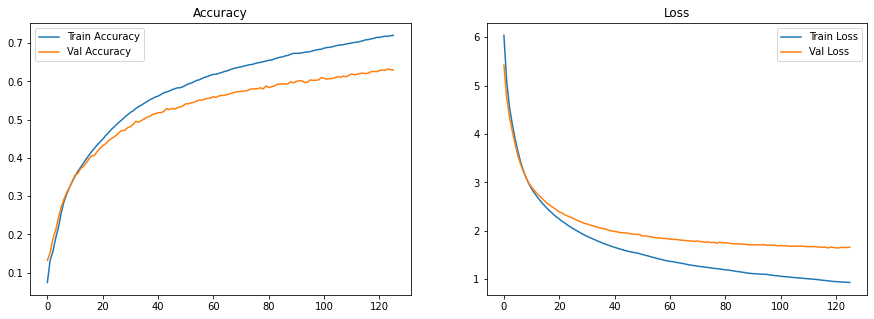

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(history.history[list(history.history)[2]], label='Train Accuracy')
axs[0].plot(history.history[list(history.history)[-2]], label='Val Accuracy')
axs[0].set_title('Accuracy')
axs[0].legend()

axs[1].plot(history.history[list(history.history)[1]], label='Train Loss')
axs[1].plot(history.history[list(history.history)[-3]], label='Val Loss')
axs[1].set_title('Loss')
axs[1].legend()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 token_and_position_embeddin  (None, 100, 72)          124488    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 100, 72)          284192    
 merBlock)                                                       
                                                                 
 transformer_block_1 (Transf  (None, 100, 72)          284192    
 ormerBlock)                                                     
                                                                 
 transformer_block_2 (Transf  (None, 100, 72)          284192